# Spiking Neural Network for CMS Muon Chamber Denoising

In [1]:
# import event simulation files
import sys
sys.path.insert(0, '../DataGeneration')
import GenEvents as ge
import PlotEvents as pe
import EventData as ed
import Params as ps

In [2]:
import numpy as np
import tqdm 
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryConfusionMatrix

import snntorch as snn
from snntorch import spikegen
import snntorch.spikeplot as splt
from snntorch import surrogate
import snntorch.functional as SF

from sklearn.metrics import ConfusionMatrixDisplay

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Generate Dataset

We will study a simplified scenario, simulating events taken in a 4x4 cell muon chamber. Signal events are not perfectly clean, but are contaminated by noise: the probability of finding noise in signal events is tuned by the *noise_frac* parameter. On the other hand, *bkg_frac* governs the ratio of noise-only events over the total number of events simulated.

In [3]:
n_evt = 30000
n_evt_test = 3000
n_evt_val = 3000

evt_arr,      muon_list,      max_n      = ge.generate_noisy_evts(n_evt,      noise_frac=0.5, bkg_frac=0.3)
evt_arr_test, muon_list_test, max_n_test = ge.generate_noisy_evts(n_evt_test, noise_frac=0.5, bkg_frac=0.3)
evt_arr_val,  muon_list_val,  max_n_val  = ge.generate_noisy_evts(n_evt_val,  noise_frac=0.5, bkg_frac=0.3)

100%|██████████| 3000/3000 [00:03<00:00, 770.34it/s]


Here is an example of a clean true event (the only hits registered are due to a muon passing through the chamber)...

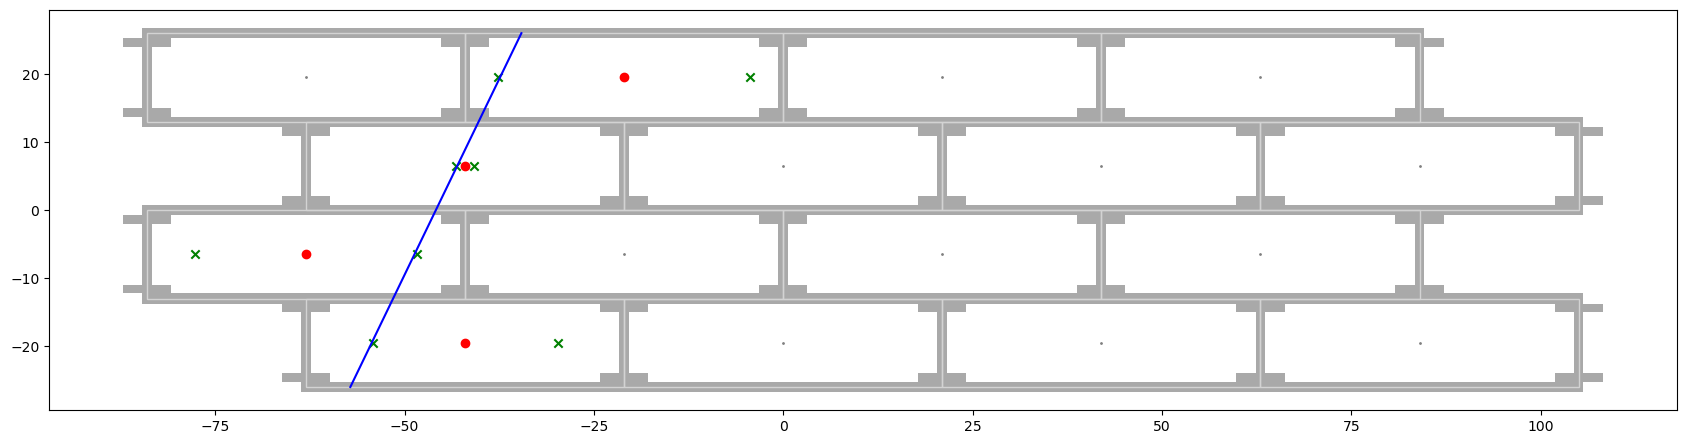

In [8]:
pe.plot_event(evt_arr[evt_arr['n_true_hits']==evt_arr['n_hits']][1])

an example of a noisy true event (a muon has actually passed through the chamber but noise has been registered as well)...

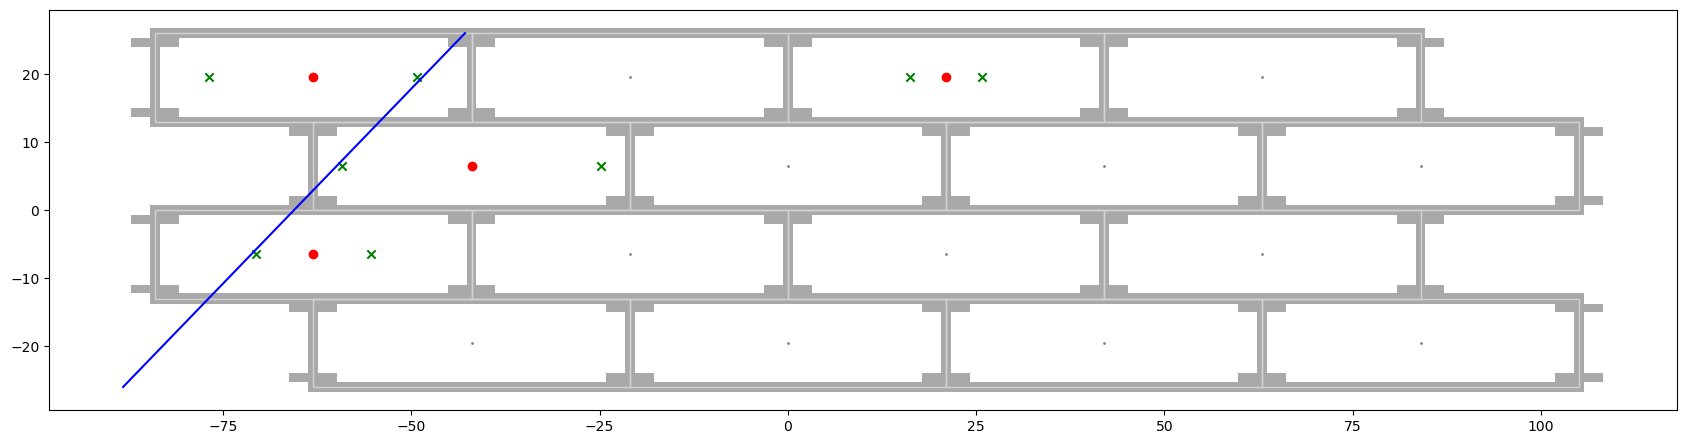

In [10]:
pe.plot_event(evt_arr[(evt_arr['n_true_hits']!=evt_arr['n_hits']) &
                      (evt_arr['n_true_hits']!=0)][1])

and finally, an example of a "fake" event (only noise has been registered)...

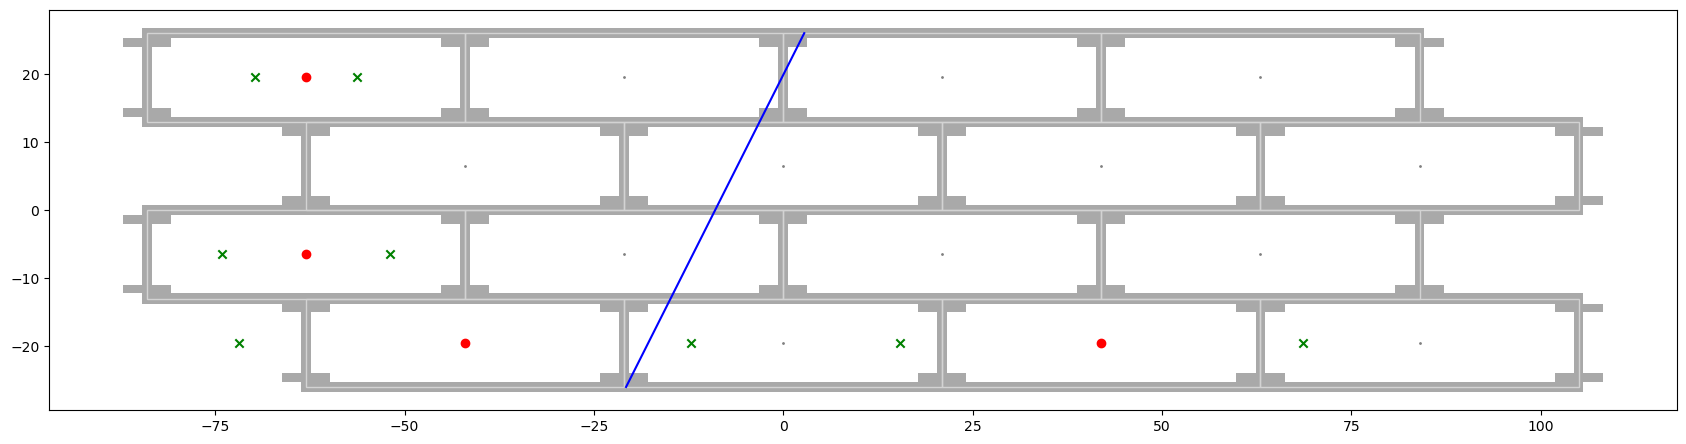

In [11]:
pe.plot_event(evt_arr[evt_arr['n_true_hits']==0][0])

To handle the generated data more easily, we will convert each event to a numpy array of fixed size, where each row will contain some information about a specific hit inside the event:

In [12]:
# transform each event (muon_hits list) to np.array of fixed size
def convert_to(muon_list, size, target_dtype, features):
    padded_array = np.zeros(shape=(len(muon_list), size, len(features)), dtype=target_dtype)
    for i, muon_hits in enumerate(muon_list):
        for j, hit in enumerate(muon_hits):
            for k, f in enumerate(features):
                padded_array[i,j,k] = hit[f]  # BEWARE: implicit type conversions going on here

    return torch.tensor(padded_array)

feature_list = ['layer', 'wire_num', 'bx', 't0', 'signal']
mu_arr      = convert_to(muon_list,      size=max_n,      target_dtype=np.float32, features=feature_list)
mu_arr_test = convert_to(muon_list_test, size=max_n_test, target_dtype=np.float32, features=feature_list)
mu_arr_val  = convert_to(muon_list_val,  size=max_n_val,  target_dtype=np.float32, features=feature_list)

### Spiketrain

The last step is to create for each input event a spiketrain to feed into the SNN. \
There are many possible encodings to choose from, but as our objective is to use this network inside the online trigger system we decided on the following: each cell of the chamber will correspond to an input neuron, and each time a hit is registered we will send a spike in the neuron corresponding to the correct cell. The time is discretised in units of "BX" (bunch crossing), equal to 25 ns.

In [13]:
def custom_spikegen(data, num_step=40, batch_size=100, linearise=True):

    spike_data = torch.zeros(size=(num_step, batch_size, ps.NLAYERS,ps.NWIRES), dtype=data.dtype)
    for n_batch, evt in enumerate(data):
        for hit in evt:
            layer = int(hit[0])
            wire = int(hit[1])
            bx = int(hit[2])
            t0 = math.floor(hit[3])
            if bx != 0:
                spike_data[bx-t0+ps.bx_oot, n_batch, layer-1, wire-1] = 1
            else:
                break
    if linearise:
        spike_data = spike_data.view(num_step, batch_size, -1)
                
    return spike_data    

Let's see an example of spiketrain:

In [14]:
def train_visualization(input_train, axs, title):
    input_train = torch.transpose(input_train,0,1)
    # Plot for input_train
    axs.imshow(input_train, cmap='binary', interpolation='nearest')
    axs.set_title(title)
    axs.set_xlabel('Timestep')
    axs.set_ylabel('Neurons')


def plot_spiketrains(trains, titles):
    n = len(titles)
    fig, axs = plt.subplots(1, n, figsize=(12, 6))
    if n==1:
        train_visualization(trains, axs, titles[0])
    else:
        for i in range(n):
            train_visualization(trains[i], axs[i], titles[i])
    # Adjust layout for better spacing
    plt.tight_layout()
    # Show the plot
    plt.show()    

tensor([[  2.0000,   3.0000, 506.0000, 500.3667,   1.0000],
        [  4.0000,   4.0000, 509.0000, 500.3667,   0.0000],
        [  1.0000,   3.0000, 510.0000, 500.3667,   1.0000],
        [  3.0000,   3.0000, 508.0000, 500.3667,   1.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])


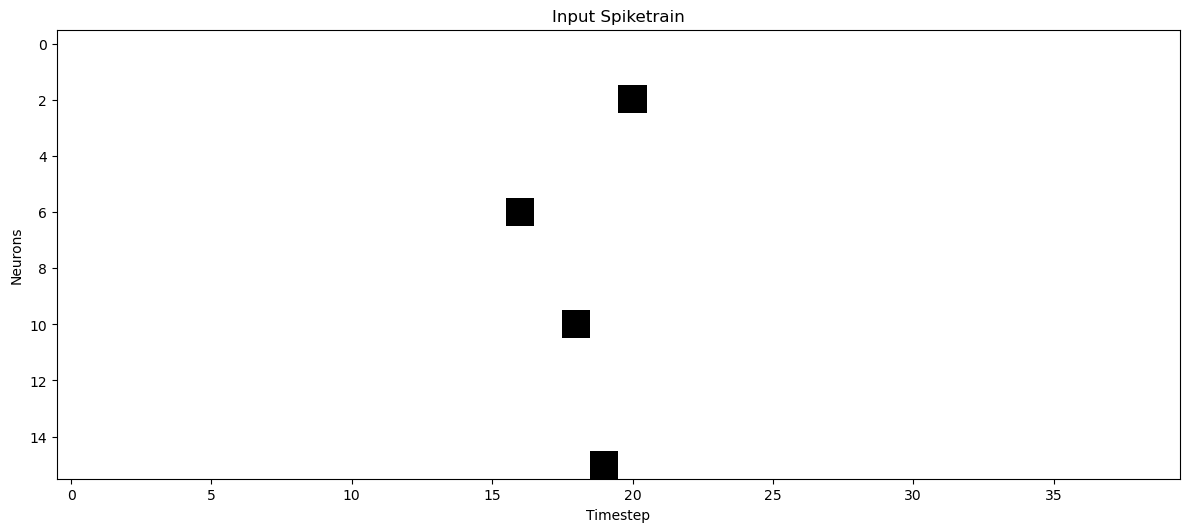

In [15]:
print(mu_arr[0])
ex_spike = custom_spikegen(mu_arr[:1,], 40, 2, True)
plot_spiketrains(ex_spike[:,0,:], ['Input Spiketrain',])

### Targets

Depending on the type of classification we want, we need to define different types of targets for the network to learn.

If we simply want to classify each event as "signal" (a muon has actually passed) or "background" (no muon but only noise), the target will be an array of binary values, respectively 1 and 0.

In [16]:
def gen_target_chamber(muon_list):
    target = np.zeros(shape=(len(muon_list)))
    for i, evt in tqdm.tqdm(enumerate(muon_list)):
        for hit in evt:
            if hit['signal'] == True:
                target[i] = 1
                break

    return torch.tensor(target, dtype=torch.long)

We can also complicate the task and try to discriminate between signal and noise for each cell inside the chamber. In this case, the target will be a 4x4 binary matrix (or vector with 16 elements) with 1 if a muon passed through the corresponding cell and 0 otherwise (noise or no hit at all). 

In [17]:
def gen_target_cell(muon_list, linearise=True):
    target = np.zeros(shape=(len(muon_list), ps.NLAYERS, ps.NWIRES))
    for i, evt in tqdm.tqdm(enumerate(muon_list)):
        for hit in evt:
            layer, wire = hit['layer']-1, hit['wire_num']-1

            if hit['signal'] == True:
                target[i, layer, wire] = 1
    target = torch.tensor(target, dtype=torch.long)
    if linearise:
        target = target.view(len(muon_list), -1)

    return target

Finally, we can try to obtain an online denoising: in this case, the target will be a spiketrain similar to the one produced by the input, but where all the hits due to noise are eliminated. The generation of the actual spiketrain, though, will be handled inside the training loop.

In [18]:
def filter_noise(muon_list):
    target_list=[]
    
    for event in muon_list:
        target_event=[]
        for hit in event:
            
            if hit["signal"] == True:
                target_event.append(hit)
        
        target_list.append(target_event)
        
    return target_list

def gen_target_timing(muon_list, size, target_dtype, features):
    filtered_list = filter_noise(muon_list)
    return convert_to(filtered_list, size, target_dtype, features)
    

### Custom Dataset and Dataloader

To easily work in the PyTorch framework we will define custom datasets and dataloaders. Each item in the dataset will be a tuple containing the array of hits and the respective target.

In [19]:
class CustomDataset(Dataset):
    def __init__(self, input_data, target, transform=None):
        self.data = list(zip(input_data, target))
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        sample = self.data[idx]
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample


# Transformations

# converts to Torch tensor of desired type
def to_tensor_and_dtype(input_variable, target_dtype=torch.float32):
    
    # Convert to PyTorch tensor
    if type(input_variable) != torch.Tensor:
        input_variable = torch.tensor(input_variable)
    # Force the tensor to have the specified dtype
    tensor = input_variable.to(target_dtype)
    
    return tensor


transform = transforms.Compose([
    lambda x: (to_tensor_and_dtype(x[0], target_dtype=torch.float32), x[1])
])

## Network Definition

Now it is time to define the network proper. We will implement three general network models:

1. Fully Connected Net with one hidden layer and LIF neurons
2. Fully Connected Net with one hidden layer and Synaptic neurons
3. Fully Connected Net with three hidden layers and Synaptic neurons

All the nets have 16 neurons in the input layer, corresponding to the 16 cells of the chamber. For the output layer, we use 2 neurons for the whole-chamber classification (one for the "signal" class and the other for "background"), 32 neurons for the cell-by-cell classification (two neurons for each cell) and finally either 16 or 32 neurons for the online denoising, depending on the loss function adopted (described later). For the hidden layers, we will use either either 100 or 30 neurons for the first two nets, and 20 neurons in all three hidden layers for the third net model. 

The neuron parameters $\alpha$, $\beta$ and $\theta$ can either be fixed from the start or learnable. The decay parameter is initialised at $\beta=0.8$ to match the theoretical expectation of having a decay time of ~16 BX.  

In [20]:
class Net_LIF_1L(nn.Module):
    """FCN with 1 hidden layer and LIF neurons."""

    def __init__(self, input_feat, hidden, out_feat, timesteps,
                 learnable, beta=0.8, threshold=1.0):
        super().__init__()
        
        self.input_feat = input_feat          # number of input neurons 
        self.hidden = hidden                  # number of hidden neurons
        self.out_feat = out_feat              # number of output neurons
        
        self.timesteps = timesteps            # number of time steps to simulate the network

        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold,
                                learn_beta=learnable, learn_threshold=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold,
                                 learn_beta=learnable, learn_threshold=learnable)
    
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
                
            cur1 = self.fc_in(x[step])
            spk1, mem1 = self.lif_in(cur1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [21]:
class Net_Syn_1L(nn.Module):
    """FCN with 1 hidden layer and Synaptic neurons."""

    def __init__(self, input_feat, hidden, out_feat, timesteps,
                 learnable, beta=0.8, threshold=1.0, alpha=0.8):
        super().__init__()
        
        self.input_feat = input_feat          # number of input neurons 
        self.hidden = hidden                  # number of hidden neurons
        self.out_feat = out_feat              # number of output neurons
        
        self.timesteps = timesteps            # number of time steps to simulate the network
        
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Synaptic(beta=beta, alpha=alpha, threshold=threshold,
                                   spike_grad=spike_grad,
                                   learn_beta=learnable, learn_threshold=learnable, learn_alpha=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Synaptic(beta=beta, alpha=alpha, threshold=threshold,
                                    spike_grad=spike_grad,
                                    learn_beta=learnable, learn_threshold=learnable, learn_alpha=learnable)
    
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        syn1, mem1 = self.lif_in.init_synaptic()
        syn2, mem2 = self.lif_out.init_synaptic()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
            cur1 = self.fc_in(x[step])
            spk1, syn1, mem1 = self.lif_in(cur1, syn1, mem1)
            
            cur2 = self.fc_out(spk1)
            spk2, syn2, mem2 = self.lif_out(cur2, syn2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [22]:
class Net_Syn_3L(nn.Module):
    """FCN with 3 hidden layers and Synaptic neurons."""

    def __init__(self, input_feat, hidden, out_feat, timesteps,
                 learnable, beta=0.8, threshold=1.0, alpha=0.8):
        super().__init__()
        
        self.input_feat = input_feat          # number of input neurons 
        self.hidden = hidden                  # number of hidden neurons
        self.out_feat = out_feat              # number of output neurons
        
        self.timesteps = timesteps            # number of time steps to simulate the network

        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden[0])
        self.lif_in = snn.Synaptic(beta=beta, alpha=alpha, threshold=threshold,
                                   spike_grad=spike_grad,
                                   learn_beta=learnable, learn_threshold=learnable, learn_alpha=learnable)
        
        self.fc_hidden1 = nn.Linear(in_features=self.hidden[0], out_features=self.hidden[1])
        self.lif_hidden1 = snn.Synaptic(beta=beta, alpha=alpha, threshold=threshold,
                                        spike_grad=spike_grad,
                                        learn_beta=learnable, learn_threshold=learnable, learn_alpha=learnable)
        
        self.fc_hidden2 = nn.Linear(in_features=self.hidden[1], out_features=self.hidden[2])
        self.lif_hidden2 = snn.Synaptic(beta=beta, alpha=alpha, threshold=threshold,
                                        spike_grad=spike_grad,
                                        learn_beta=learnable, learn_threshold=learnable, learn_alpha=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden[2], out_features=self.out_feat)
        self.lif_out = snn.Synaptic(beta=beta, alpha=alpha, threshold=threshold,
                                    spike_grad=spike_grad,
                                    learn_beta=learnable, learn_threshold=learnable, learn_alpha=learnable)
        
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        syn1, mem1 = self.lif_in.init_synaptic()
        synh1, memh1 = self.lif_hidden1.init_synaptic()
        synh2, memh2 = self.lif_hidden2.init_synaptic()
        syn2, mem2 = self.lif_out.init_synaptic()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
            cur1 = self.fc_in(x[step])
            spk1, syn1, mem1 = self.lif_in(cur1, syn1, mem1)
            
            curh1 = self.fc_hidden1(spk1)
            spkh1, synh1, memh1 = self.lif_hidden1(curh1, synh1, memh1)
            
            curh2 = self.fc_hidden2(spkh1)
            spkh2, synh2, memh2 = self.lif_hidden2(curh2, synh2, memh2)
            
            cur2 = self.fc_out(spkh2)
            spk2, syn2, mem2 = self.lif_out(cur2, syn2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

### Loss Function
For the classification tasks, as the basis for the loss function we will use the *ce_count_loss* as defined by *snntorch*: 
>The spikes at each time step [num_steps x batch_size x num_outputs] are accumulated and then passed through the Cross Entropy Loss function. This criterion combines log_softmax and NLLLoss in a single function. The Cross Entropy Loss encourages the correct class to fire at all time steps, and aims to suppress incorrect classes from firing.

This loss works well when classifying the whole chamber, but needs to be tweaked when dealing with per-cell classification. For the latter, we need to define a custom loss that computes the *ce_count_loss* for each cell (corresponding to a pair of neurons) and sums the total together.

In [23]:
class Multi_loss(nn.Module):
    def __init__(self, n_classes, loss_func, timing):
        super(Multi_loss, self).__init__()
        self.n_classes = n_classes
        self.loss = loss_func
        self.timing = timing

    def forward(self, inputs, targets):
        loss = 0
        for i in range(inputs.shape[-1]//self.n_classes):
            if self.timing:
                loss += self.loss(inputs[:, :, i*self.n_classes:(i+1)*self.n_classes],
                                  targets[:, :, i])
            else:
                loss += self.loss(inputs[:, :, i*self.n_classes:(i+1)*self.n_classes],
                                  targets[:, i])
        return loss

For the online denoising, on the other hand, the simplest implementation is a MSE loss that compares the output spiketrain with the spiketrain produced by the denoised target. In order to avoid all outputs to go to zero, considering a signal as noise (false negative) will be more heavily penalised.

In [24]:
class Weighted_MSE_loss(nn.Module):
    def __init__(self, weights, reduction):
        super(Weighted_MSE_loss, self).__init__()
        self.weights = weights
        self.reduction = reduction

    def forward(self, output, targets):
        diff = output - targets
        diff[diff > 0] *= self.weights[0]
        diff[diff < 0] *= self.weights[1]

        if self.reduction == 'mean':
            return torch.mean(diff ** 2)
        else:
            return torch.sum(diff ** 2)


A more refined approach consists of using the cross entropy on the membrane potentials at each time step, either using two different output neurons per cell or using BCE on a single neuron (after applying a sigmoid function to have the output inside the [0,1] range).

In [26]:
class LossFunctions:
    def _prediction_check(self, spk_out):
        device = spk_out.device

        num_steps = spk_out.size(0)
        num_outputs = spk_out.size(-1)

        return device, num_steps, num_outputs

    def _population_code(self, spk_out, num_classes, num_outputs):
        """Count up spikes sequentially from output classes."""
        if not num_classes:
            raise Exception(
                "``num_classes`` must be specified if "
                "``population_code=True``."
            )
        if num_outputs % num_classes:
            raise Exception(
                f"``num_outputs {num_outputs} must be a factor "
                f"of num_classes {num_classes}."
            )
        device = spk_out.device
        pop_code = torch.zeros(tuple([spk_out.size(1)] + [num_classes])).to(
            device
        )
        for idx in range(num_classes):
            pop_code[:, idx] = (
                spk_out[
                    :,
                    :,
                    int(num_outputs * idx / num_classes) : int(
                        num_outputs * (idx + 1) / num_classes
                    ),
                ]
                .sum(-1)
                .sum(0)
            )
        return pop_code



class ce_mem_loss_timing(LossFunctions):
    """Cross Entropy Membrane Rate Loss.
    When called, the membrane potential values at each time step are
    sequentially passed through the Cross Entropy Loss function.
    This criterion combines log_softmax and NLLLoss in a single function.
    The losses are accumulated over time steps to give the final loss.
    The Cross Entropy Loss encourages the membrane potential of
    the correct class to increase in presence of a signal, while suppressing the
    membrane potential of incorrect classes. In absence of a signal, this
    trend is reversed.

    Example::

        import snntorch.functional as SF

        loss_fn = SF.ce_mem_loss_timing()
        loss = loss_fn(outputs, targets)

    :return: Loss
    :rtype: torch.Tensor (single element)

    """

    def __init__(self):
        self.__name__ = "ce_mem_loss_timing"

    def __call__(self, mem_out, targets):
        device, num_steps, _ = self._prediction_check(mem_out)
        log_softmax_fn = nn.LogSoftmax(dim=-1)
        loss_fn = nn.NLLLoss()

        log_p_y = log_softmax_fn(mem_out)
        loss = torch.zeros((1), dtype=torch.float, device=device)

        for step in range(num_steps):
            loss += loss_fn(log_p_y[step], targets[step])

        return loss / num_steps
    
    
class bce_mem_loss_timing(LossFunctions):
    """Binary Cross Entropy Membrane Rate Loss.
    When called, the membrane potential values at each time step are
    sequentially passed through the Binary Cross Entropy with Logits
    Loss function. The losses are accumulated over time steps to give 
    the final loss. The Cross Entropy Loss encourages the membrane potential
    of the correct neuron to increase in the presence of a signal, while
    suppressing the membrane potential at other times.


    Example::

        import snntorch.functional as SF

        loss_fn = SF.bce_mem_loss_timing()
        loss = loss_fn(outputs, targets)

    :return: Loss
    :rtype: torch.Tensor (single element)

    """

    def __init__(self):
        self.__name__ = "bce_mem_loss_timing"

    def __call__(self, mem_out, targets):
        device, num_steps, _ = self._prediction_check(mem_out)
        loss_fn = nn.BCEWithLogitsLoss()
        
        loss = torch.zeros((1), dtype=torch.float, device=device)

        for step in range(num_steps):
            loss += loss_fn(mem_out[step], targets[step].float())

        return loss / num_steps

### Accuracy

We now define the accuracy functions based on the task. When dealing with cell-by-cell classification or online denoising, we can decide if we want an accuracy per single cell or a global accuracy for the whole event.

In [27]:
def comp_accuracy(output, targets, type):
    total = 0
    correct = 0
    predicted = None

    # whole chamber classification
    if type == 'chamber':
        _, predicted = output.sum(dim=0).max(1)
        total = targets.size(0)
        correct = (predicted == targets).sum().item()

    # cell-by-cell classification
    elif type == 'cell':
        batch_size = targets.size(0)
        _, predicted = output.sum(dim=0).view(batch_size, ps.NLAYERS*ps.NWIRES, -1).max(2)
        total = targets.numel()
        correct = (predicted == targets).sum().item()

    # accuracy on the whole event for cell-by-cell classification
    elif type == 'cell_per_evt':
        batch_size = targets.size(0)
        total = batch_size
        _, predicted = output.sum(dim=0).view(batch_size, ps.NLAYERS*ps.NWIRES, -1).max(2)
        for i in range(batch_size):
            correct += torch.sum((predicted[i] == targets[i]).all())

    # accuracy cell-by-cell moment-by-moment for precise timing recontruction
    # (MSE loss)
    elif type == 'mse_timing':
        total = targets.numel()
        correct = (output == targets).sum().item()
        predicted = output

    # accuracy on the whole event for timing reconstruction
    # (MSE loss)
    elif type == 'mse_timing_per_evt':
        batch_size = targets.size(1)
        total = batch_size
        for i in range(batch_size):
            correct += torch.sum((output[:, i] == targets[:, i]).all())
        predicted = output

    # accuracy cell-by-cell moment-by-moment for precise timing recontruction
    # (CEMRL)
    elif type == "ce_timing":
        num_steps = targets.size(0)
        batch_size = targets.size(1)
        total = targets.numel()
        _, predicted = output.view(num_steps, batch_size, ps.NLAYERS*ps.NWIRES, -1).max(3)
        correct = (predicted == targets).sum().item()

    # accuracy on the whole event for timing reconstruction
    # (CEMRL)
    elif type == "ce_timing_per_evt":
        num_steps = targets.size(0)
        batch_size = targets.size(1)
        total = batch_size
        _, predicted = output.view(num_steps, batch_size, ps.NLAYERS*ps.NWIRES, -1).max(3)
        for i in range(batch_size):
            correct += torch.sum((predicted[:, i] == targets[:, i]).all())

    # accuracy cell-by-cell moment-by-moment for precise timing recontruction
    # (BCEMRL)
    elif type == "bce_timing":
        total = targets.numel()
        sigmoid = nn.Sigmoid()
        predicted = sigmoid(output)
        predicted[predicted <  0.5] = 0
        predicted[predicted >= 0.5] = 1
        correct = (predicted == targets).sum().item()

    # accuracy on the whole event for timing reconstruction
    # (BCEMRL)
    elif type == "bce_timing_per_evt":
        batch_size = targets.size(1)
        total = batch_size
        sigmoid = nn.Sigmoid()
        predicted = sigmoid(output)
        predicted[predicted <  0.5] = 0
        predicted[predicted >= 0.5] = 1
        for i in range(batch_size):
            correct += torch.sum((predicted[:, i] == targets[:, i]).all())
   

    return total, correct, predicted

This function computes mean loss, accuracy and optionally the confusion matrix on a whole dataset:

In [29]:
def accuracy_set(net, data_loader, loss_fn, accuracy_type, num_steps,
                 batch_size, CM, timing, linearise, use_membrane):
    bcm = BinaryConfusionMatrix()
    net.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        temp_loss = []
        cm = torch.tensor([[0,0],[0,0]])
        for data, targets in data_loader:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data, num_steps, batch_size, linearise)
            spike_in = spike_in.to(device)
            if timing:
                targets = custom_spikegen(targets, num_steps, batch_size, linearise).type(torch.long)

            # forward pass
            spk_rec, mem_rec = net(spike_in)
            output = None
            if use_membrane:
                output = mem_rec
            else:
                output = spk_rec

            # compute loss
            loss = loss_fn(output, targets)
            temp_loss.append(loss.item())

            # calculate total accuracy
            tot, corr, pred = comp_accuracy(output, targets, accuracy_type)
            total += tot
            correct += corr
            if CM:
                cm += bcm(pred, targets)

        mean_loss = np.mean(temp_loss)
        acc = correct/total
        if CM:
            cm = cm/cm.sum()

        return mean_loss, acc, cm

### Training

Training loop:

In [44]:
def train_net(net, train_loader, val_loader, num_epochs, loss_fn, optimizer, accuracy_type,
              num_steps, batch_size, linearise=True, timing=False, use_membrane=False):

    net.to(device)
    
    loss_hist = []
    loss_val_hist = []
    acc_val_hist = []

    iter_counter = 0

    # Validation
    mean_loss_val, acc_val, _ = accuracy_set(net, val_loader, loss_fn, accuracy_type, num_steps,
                                             batch_size, False, timing, linearise, use_membrane)

    loss_val_hist.append(mean_loss_val)
    acc_val_hist.append(acc_val)
    print(f"Validation Set Loss: {mean_loss_val}")
    print(f"Validation Set Accuracy: {100 *acc_val:.2f}%")
    print("\n--------------------------------------------------\n")

    for epoch in range(num_epochs):
        net.train()
        batch_counter = 0
        # Minibatch training loop
        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data, num_steps, batch_size, linearise)
            spike_in = spike_in.to(device)
            if timing:
                targets = custom_spikegen(targets, num_steps, batch_size, linearise).type(torch.long)

            # forward pass
            spk_rec, mem_rec = net(spike_in)
            output = None
            if use_membrane:
                output = mem_rec
            else:
                output = spk_rec

            # compute loss
            loss_val = loss_fn(output, targets)
        
            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Store loss history for future plotting
            loss_hist.append(loss_val.item())
        
            if iter_counter % 50 == 0:
                print("Epoch:", epoch+1)
                print("Batch:", batch_counter)
                print("Iteration:", iter_counter)
                print("Loss:", loss_val.item(),"\n")
        
            batch_counter += 1
            iter_counter += 1

        # Validation
        mean_loss_val, acc_val, _ = accuracy_set(net, val_loader, loss_fn, accuracy_type, num_steps,
                                                 batch_size, False, timing, linearise, use_membrane)

        loss_val_hist.append(mean_loss_val)
        acc_val_hist.append(acc_val)
        print(f"Validation Set Loss: {mean_loss_val}")
        print(f"Validation Set Accuracy: {100 *acc_val:.2f}%")
        print("\n--------------------------------------------------\n")

    return loss_hist, loss_val_hist, acc_val_hist

## Examples

### Chamber Classification

In [30]:
target      = gen_target_chamber(muon_list)
target_test = gen_target_chamber(muon_list_test)
target_val  = gen_target_chamber(muon_list_val)

30000it [00:00, 111418.08it/s]
3000it [00:00, 166365.81it/s]
3000it [00:00, 96657.05it/s]


In [31]:
train_dataset = CustomDataset(mu_arr,      target,      transform=transform)
test_dataset  = CustomDataset(mu_arr_test, target_test, transform=transform)
val_dataset   = CustomDataset(mu_arr_val,  target_val,  transform=transform)

batch_size = 100
nw=0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True, num_workers=nw)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=nw)

In [40]:
num_inputs = 16
num_hidden = 100
num_output = 2
timesteps  = 40
learnable  = True
beta       = 0.8
threshold  = 1.0
alpha      = 0.8

net = Net_Syn_1L(num_inputs, num_hidden, num_output, timesteps, learnable, beta, threshold, alpha).to(device)

In [41]:
loss_fn = SF.ce_count_loss()
accuracy_type = 'chamber'
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
num_epochs = 5

loss_hist, loss_val_hist, acc_val_hist = train_net(net,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn, optimizer,
                                                   accuracy_type, timesteps, batch_size,
                                                   True, False, False)

Validation Set Loss: 0.6931473016738892
Validation Set Accuracy: 29.57%

--------------------------------------------------

Epoch: 0
Batch: 0
Iteration: 0
Loss: 0.6931473016738892 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.3980425000190735 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.38937652111053467 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.38155224919319153 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.14107798039913177 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.1671351194381714 

Validation Set Loss: 0.12818476085861524
Validation Set Accuracy: 93.63%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 300
Loss: 0.08764666318893433 

Epoch: 1
Batch: 50
Iteration: 350
Loss: 0.11052476614713669 

Epoch: 1
Batch: 100
Iteration: 400
Loss: 0.041573066264390945 

Epoch: 1
Batch: 150
Iteration: 450
Loss: 0.1099533960223198 

Epoch: 1
Batch: 200
Iteration: 500
Loss: 0.176592618227005 

Epoch: 1
Batch: 250
Iteration: 550
Loss: 0.18094110488891602 

Validat

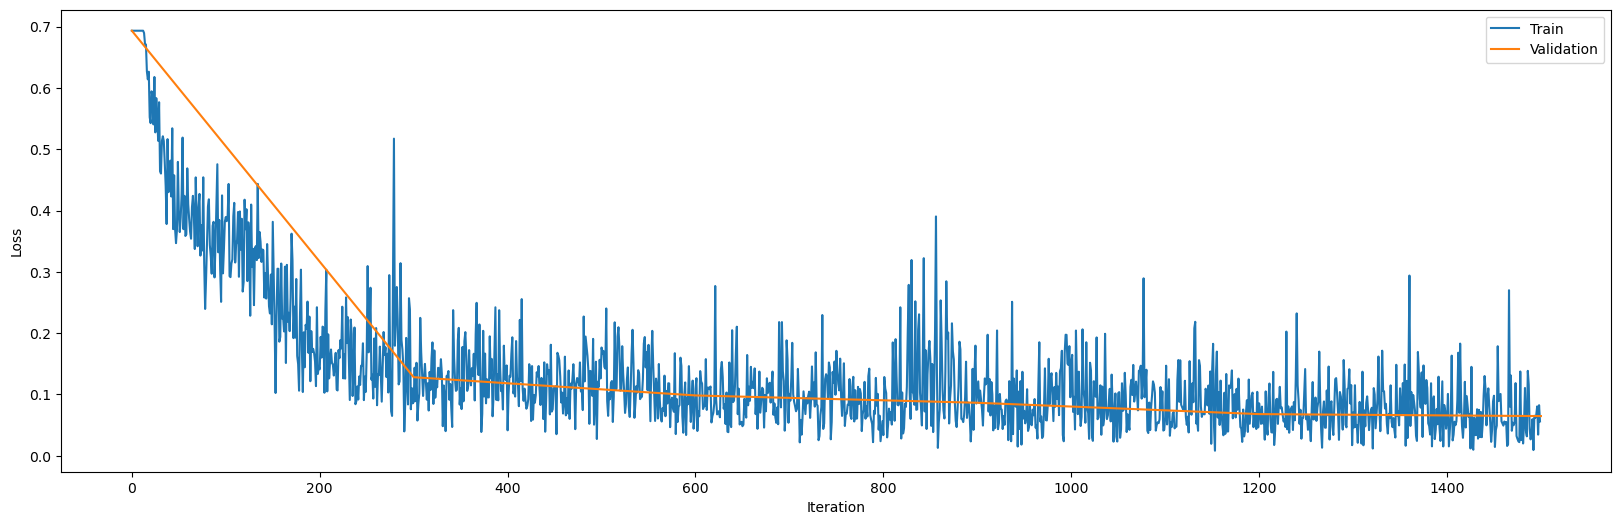

In [42]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
x1 = np.arange(n_evt/batch_size*num_epochs)
x2 = np.arange(0, n_evt/batch_size*num_epochs+1, n_evt/batch_size)
plt.plot(x1, loss_hist,     label='Train')
plt.plot(x2, loss_val_hist, label='Validation')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

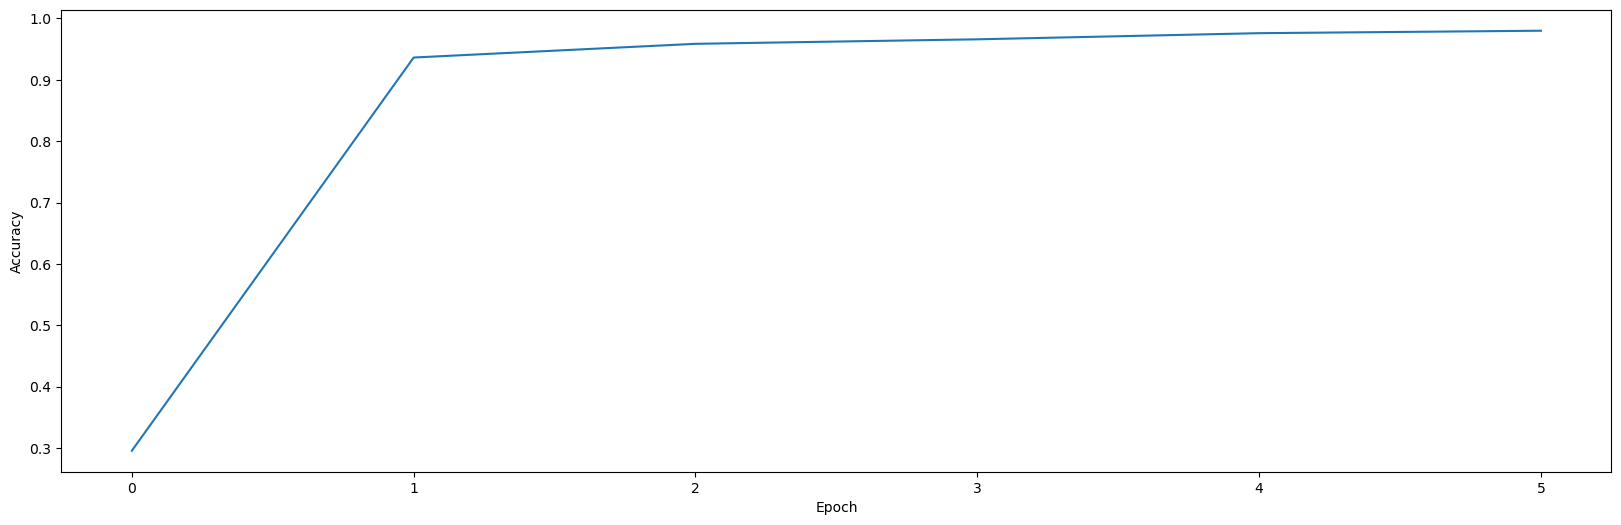

In [43]:
# Plot accuracy
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist,  label='Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

Test Set Loss: 0.06607243288308381
Test Set Accuracy: 98.30%


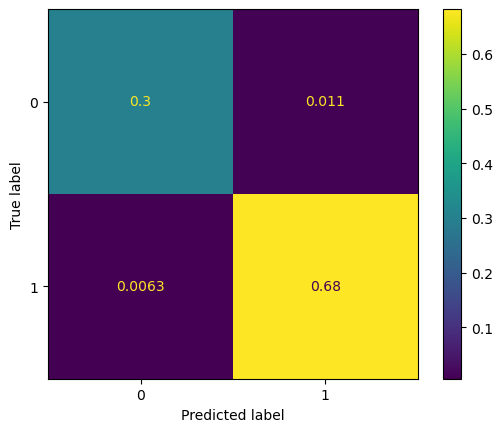

In [46]:
mean_loss_test, acc_test, cm = accuracy_set(net, test_loader, loss_fn, 'chamber', timesteps,
                                            batch_size, True, False, True, False)
print(f"Test Set Loss: {mean_loss_test}")
print(f"Test Set Accuracy: {100 *acc_test:.2f}%")

ConfusionMatrixDisplay(confusion_matrix=cm.numpy()).plot()


### Cell-by-Cell Classification

In [47]:
target      = gen_target_cell(muon_list, True)
target_test = gen_target_cell(muon_list_test, True)
target_val  = gen_target_cell(muon_list_val, True)

30000it [00:00, 162962.59it/s]
3000it [00:00, 149689.65it/s]
3000it [00:00, 142872.36it/s]


In [48]:
train_dataset = CustomDataset(mu_arr,      target,      transform=transform)
test_dataset  = CustomDataset(mu_arr_test, target_test, transform=transform)
val_dataset   = CustomDataset(mu_arr_val,  target_val,  transform=transform)

batch_size = 100
nw=0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True, num_workers=nw)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=nw)

In [49]:
num_inputs = 16
num_hidden = 100
num_output = 32
timesteps  = 40
learnable  = True
beta       = 0.8
threshold  = 1.0
alpha      = 0.8

net = Net_Syn_1L(num_inputs, num_hidden, num_output, timesteps, learnable, beta, threshold, alpha).to(device)

In [50]:
loss_fn = Multi_loss(2, SF.ce_count_loss(), False)
accuracy_type = 'cell_per_evt'
optimizer = torch.optim.Adam(net.parameters(), lr=2e-3, betas=(0.9, 0.999))
num_epochs = 5

loss_hist, loss_val_hist, acc_val_hist = train_net(net,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn, optimizer,
                                                   accuracy_type, timesteps, batch_size,
                                                   True, False, False)

Validation Set Loss: 97.82770309448242
Validation Set Accuracy: 0.00%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 0
Loss: 101.2801284790039 

Epoch: 1
Batch: 50
Iteration: 50
Loss: 8.05755615234375 

Epoch: 1
Batch: 100
Iteration: 100
Loss: 6.207275390625 

Epoch: 1
Batch: 150
Iteration: 150
Loss: 3.885305166244507 

Epoch: 1
Batch: 200
Iteration: 200
Loss: 2.9872212409973145 

Epoch: 1
Batch: 250
Iteration: 250
Loss: 2.197338104248047 

Validation Set Loss: 1.758631996313731
Validation Set Accuracy: 45.87%

--------------------------------------------------

Epoch: 2
Batch: 0
Iteration: 300
Loss: 1.6406610012054443 

Epoch: 2
Batch: 50
Iteration: 350
Loss: 1.7287812232971191 

Epoch: 2
Batch: 100
Iteration: 400
Loss: 1.3661624193191528 

Epoch: 2
Batch: 150
Iteration: 450
Loss: 1.4585376977920532 

Epoch: 2
Batch: 200
Iteration: 500
Loss: 1.3361761569976807 

Epoch: 2
Batch: 250
Iteration: 550
Loss: 1.3294124603271484 

Validation Set Loss: 0.9356

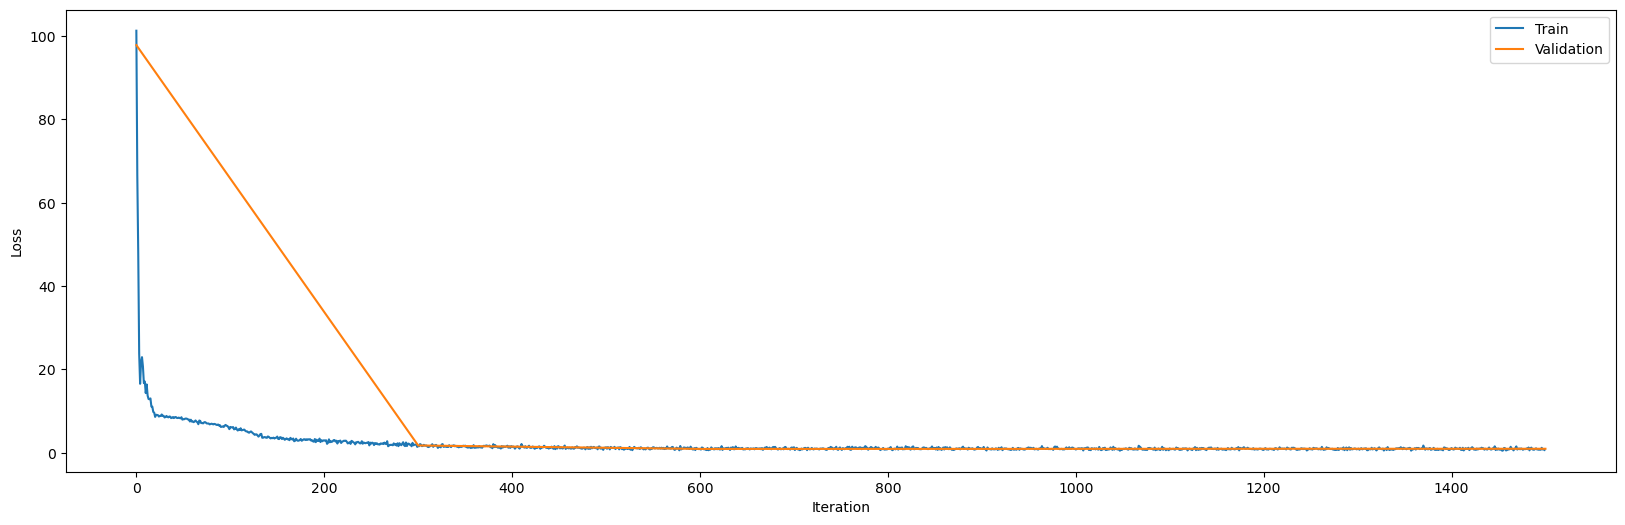

In [51]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
x1 = np.arange(n_evt/batch_size*num_epochs)
x2 = np.arange(0, n_evt/batch_size*num_epochs+1, n_evt/batch_size)
plt.plot(x1, loss_hist,     label='Train')
plt.plot(x2, loss_val_hist, label='Validation')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

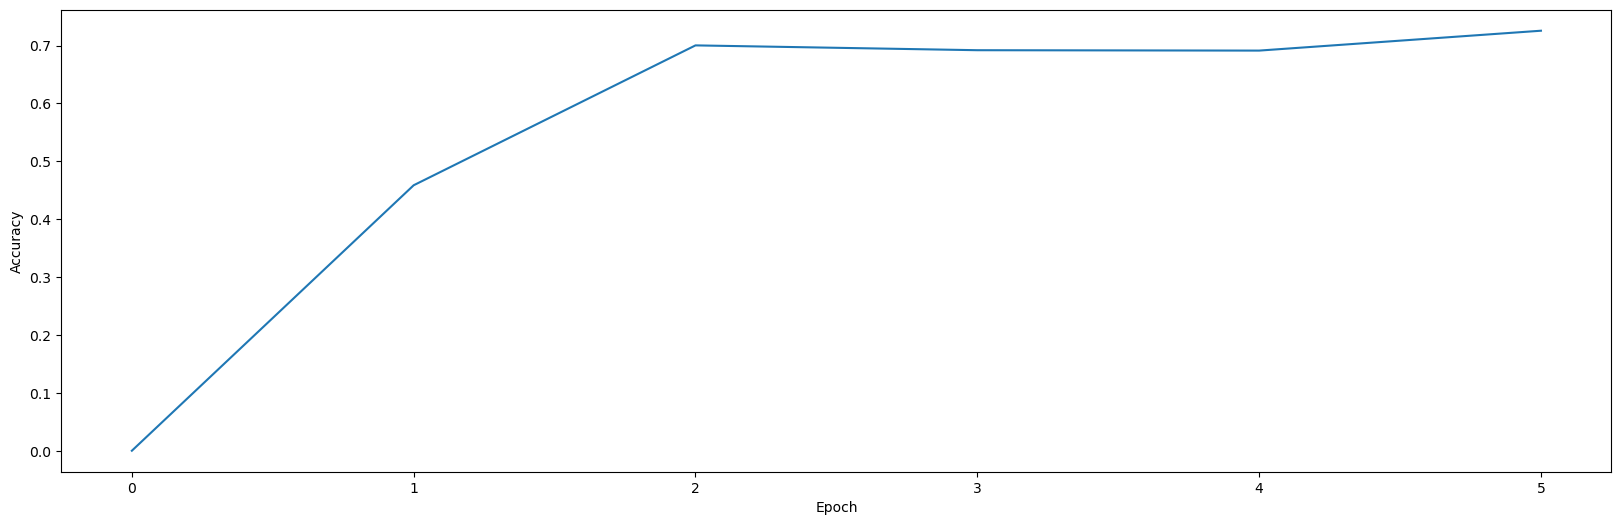

In [52]:
# Plot accuracy
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist,  label='Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

Analysing cell-by-cell:
Test Set Loss: 0.9736908415953318
Test Set Accuracy: 97.72%
Analysing event-per-event:
Test Set Loss: 0.9736908386150996
Test Set Accuracy: 73.03%


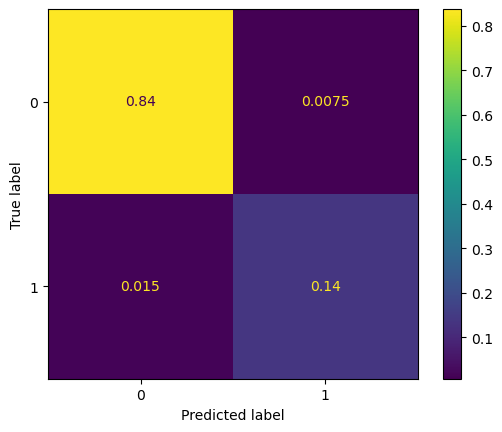

In [53]:
mean_loss_test, acc_test, cm = accuracy_set(net, test_loader, loss_fn, 'cell', timesteps,
                                            batch_size, True, False, True, False)
print("Analysing cell-by-cell:")
print(f"Test Set Loss: {mean_loss_test}")
print(f"Test Set Accuracy: {100 *acc_test:.2f}%")

mean_loss_test, acc_test, _ = accuracy_set(net, test_loader, loss_fn, 'cell_per_evt', timesteps,
                                           batch_size, False, False, True, False)
print("Analysing event-per-event:")
print(f"Test Set Loss: {mean_loss_test}")
print(f"Test Set Accuracy: {100 *acc_test:.2f}%")

ConfusionMatrixDisplay(confusion_matrix=cm.numpy()).plot()

### Precise Timing

In [ ]:
target      = gen_target_timing(muon_list,      size=max_n,      target_dtype=np.float32, features=feature_list)
target_test = gen_target_timing(muon_list_test, size=max_n_test, target_dtype=np.float32, features=feature_list)
target_val  = gen_target_timing(muon_list_val,  size=max_n_val,  target_dtype=np.float32, features=feature_list)

In [ ]:
train_dataset = CustomDataset(mu_arr,      target,      transform=transform)
test_dataset  = CustomDataset(mu_arr_test, target_test, transform=transform)
val_dataset   = CustomDataset(mu_arr_val,  target_val,  transform=transform)

batch_size = 100
nw=0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True, num_workers=nw)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=nw)

In [ ]:
net = Net(num_inputs, num_hidden, num_inputs, num_steps).to(device)

In [ ]:
loss_fn = Weighted_MSE_loss([50,1], 'sum')
accuracy_type = 'mse_timing'
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
num_epochs = 5

loss_hist, loss_val_hist, acc_val_hist = train_net(net,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn, optimizer,
                                                   accuracy_type, batch_size, True, True)

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
x1 = np.arange(n_evt/batch_size*num_epochs)
x2 = np.arange(n_evt/batch_size, n_evt/batch_size*num_epochs+1, n_evt/batch_size)
plt.plot(x1, loss_hist,     label='Train')
plt.plot(x2, loss_val_hist, label='Validation')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Plot accuracy
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist,  label='Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
mean_loss_test, acc_test = accuracy_set(net, test_loader, loss_fn, 'mse_timing', batch_size, True, True)
print("Analysing cell-by-cell and moment-by-moment:")
print(f"Test Set Loss: {mean_loss_test}")
print(f"Test Set Accuracy: {100 *acc_test:.2f}%")

mean_loss_test, acc_test = accuracy_set(net, test_loader, loss_fn, 'mse_timing_per_evt', batch_size, True, True)
print("Analysing event-per-event:")
print(f"Test Set Loss: {mean_loss_test}")
print(f"Test Set Accuracy: {100 *acc_test:.2f}%")


In [ ]:
net = Net(num_inputs, num_hidden, num_outputs_cell, num_steps).to(device)

In [ ]:
loss_fn = Multi_loss(2, ce_mem_loss_timing(), True)
accuracy_type = 'ce_timing'
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
num_epochs = 3

loss_hist, loss_val_hist, acc_val_hist = train_net(net,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn, optimizer,
                                                   accuracy_type, batch_size, True, True, True)

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
x1 = np.arange(n_evt/batch_size*num_epochs)
x2 = np.arange(n_evt/batch_size, n_evt/batch_size*num_epochs+1, n_evt/batch_size)
plt.plot(x1, loss_hist,     label='Train')
plt.plot(x2, loss_val_hist, label='Validation')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Plot accuracy
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist,  label='Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
mean_loss_test, acc_test = accuracy_set(net, test_loader, loss_fn, 'ce_timing', batch_size, True, True, True)
print("Analysing cell-by-cell and moment-by-moment:")
print(f"Test Set Loss: {mean_loss_test}")
print(f"Test Set Accuracy: {100 *acc_test:.2f}%")

In [ ]:
net = Net(num_inputs, num_hidden, num_inputs, num_steps).to(device)

In [ ]:
loss_fn = bce_mem_loss_timing()
accuracy_type = 'bce_timing'
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
num_epochs = 5

loss_hist, loss_val_hist, acc_val_hist = train_net(net,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn, optimizer,
                                                   accuracy_type, batch_size, True, True, True)

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
x1 = np.arange(n_evt/batch_size*num_epochs)
x2 = np.arange(n_evt/batch_size, n_evt/batch_size*num_epochs+1, n_evt/batch_size)
plt.plot(x1, loss_hist,     label='Train')
plt.plot(x2, loss_val_hist, label='Validation')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Plot accuracy
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist,  label='Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
mean_loss_test, acc_test = accuracy_set(net, test_loader, loss_fn, 'bce_timing', batch_size, True, True, True)
print("Analysing cell-by-cell and moment-by-moment:")
print(f"Test Set Loss: {mean_loss_test}")
print(f"Test Set Accuracy: {100 *acc_test:.2f}%")

In [ ]:
counter = 0
counter_tgt = 0
sigmoid = nn.Sigmoid()
with torch.no_grad():
    for data, targets in val_loader:

    #print("data shape:", data.shape)
    #print("data[2]:", data[2])

    #print("\nTarget shape:", targets.shape)
    #print("Target[2]:", targets[2])

        spike_in = custom_spikegen(data, num_steps)
        spk_rec, mem_rec = net(spike_in)

    #print("\nmem_rec shape:", mem_rec.shape)

        targets = custom_spikegen(targets, num_steps, batch_size, True).type(torch.long)
    #print("New target shape:", targets.shape)
        predicted = sigmoid(mem_rec)
        predicted[predicted <  0.5] = 0
        predicted[predicted >= 0.5] = 1
    
        for i in range(batch_size):
            if torch.count_nonzero(targets[:,i]) != 0:
                counter_tgt += 1
            if torch.count_nonzero(predicted[:,i]) != 0:
                counter += 1
                plot_spiketrains([spike_in[:,i], targets[:,i], predicted[:,i]], ['Input','Target', 'Output'])

    '''
    spk_count = spk_rec.sum(dim=0)
    print("\nspk_count shape:", spk_count.shape)

    print("spk_count[2]:", spk_count[2])

    a = spk_count.view(batch_size, ps.NLAYERS*ps.NWIRES, -1)
    print("\na shape:", a.shape)
    print("a[2]:", a[2])

    _, b = a.max(2)
    print("\nb shape:", b.shape)
    print("b[2]:", b[2])
    
    c = b.view(batch_size, ps.NLAYERS, -1)
    print("\nc shape:", c.shape)
    print("c[2]:", c[2])

    new_target = targets.view(batch_size, -1)
    print("\nlinearised targets shape:", new_target.shape)
    print("linearised targtes[2]:", new_target[2])
    print("")
    
    break'''

print(counter, counter_tgt)

In [ ]:
counter = 0
counter_tgt = 0
sigmoid = nn.Sigmoid()
with torch.no_grad():
    for data, targets in val_loader:
        print(targets.shape)

        spike_in = custom_spikegen(data, num_steps)
        spk_rec, mem_rec = net(spike_in)

        print(mem_rec[:,0])
        print(spike_in[:,0])
        print(spk_rec[:,0])
        plot_spiketrains([spike_in[:,0], spk_rec[:,0]], ['Input', 'Output'])

        break
    
        for i in range(batch_size):
            plot_spiketrains([spike_in[:,i], spk_rec[:,i]], ['Input', 'Output'])
            

        break


In [ ]:
counter = 0
counter_tgt = 0
sigmoid = nn.Sigmoid()
with torch.no_grad():
    for data, targets in val_loader:
        print(targets.shape)

        spike_in = custom_spikegen(data, num_steps)
        spk_rec, mem_rec = net(spike_in)

        for i in range(32):
            print(mem_rec[:,0,i])
        #print(spike_in[:,0])
        #print(spk_rec[:,0])
        plot_spiketrains([spike_in[:,0], spk_rec[:,0]], ['Input', 'Output'])

        break
    
        for i in range(batch_size):
            plot_spiketrains([spike_in[:,i], spk_rec[:,i]], ['Input', 'Output'])
            

        break